**Author: Ansh Gupta**

## Project Description:

See the accompanying report, **Final Project Report.pdf**, for a full description of the theory, procedure, results, and discussion.

Consider a system of fermions in a 3 dimensional, cubical box with side length $L$. Analytically, the expected relationship between the side length of the box and the average energy of the system can be found in terms of the volume of the box (V), its surface area (A), a small fluctuating term ($\delta{E}$). 

$$ E = \rho_E{V} + \sigma_E{A} + \delta{E} $$

Here, I reproduce this relationship by calculating the averge total energy of a fermi gas for a variety of box side lengths. The analysis is carried out for mutliple regimes of temperatures and chemical potentials. By fitting the analytical form of the relationship to the computed values, the derived energy density of the Fermi gas $\rho_E$, surface energy $\sigma_E$, and fluctuation term $\delta{E}$ are found.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit

In [2]:
hbar = 1.055e-34 # reduced Planck's constant in units of J*s
m = 9.109e-31 # mass of electron in kg
kB = 1.381e-23 # Boltzman constant in units of J/K

In [3]:
@njit
def state_energy(n_sq_mag, L):
    ''' Function that computes the energy of a particle in a 3D box in a state with 
        specified quantum numbers and the side length of the box.
        
    Inputs:
        n_sq_mag: `int`
            Square magnitude of the n vector, or nx^2 + ny^2 + nz^2
        L: `float`
            Side length of the 3D cube (meters)
    Returns: 
        energy_of_state: `float`
            Calculated energy of a particle-in-a-box in the given state
    '''
    
    energy_of_state = np.pi**2 * hbar**2 * n_sq_mag / (2 * m * L**2)
    return energy_of_state

In [4]:
@njit
def FD_distribution(n_sq_mag, L, beta, mu):
    ''' Function that computes the value of the Fermi_Dirac distribution for a particle in
        a 3D box in a state with specified quantum numbers, given the side length of the box
        and the "thermodynamic beta" (1/kT) and chemical potential.
        
    Inputs:
        n_sq_mag: `int`
            Square magnitude of the n vector, or nx^2 + ny^2 + nz^2
        L: `float`
            Side length of the 3D cube (meters)
        beta: `float`
            Thermodynamic beta (1/kT) in units of eV
        mu: `float`
            Chemical potential of fermi gas in units of eV
    Returns: 
        FD: `float`
            Calculated value of the Fermi-Dirac distribution
    '''
    
    FD = 1 / (1 + np.exp(beta * (state_energy(n_sq_mag, L) - mu)) )
    return FD

In [5]:
@njit
def system_energy(beta, mu, L_min, L_max, n_L=100, n_max=100):
    ''' Function that computes the average energy of a system of fermions in a 3D box
        by summing over all combinations of quantum numbers to a specified upper limit.
        Energy values for a range of lengths are computed and returned.
        
    Inputs:
        beta: `float`
            Thermodynamic beta (1/kT) in units of eV
        mu: `float`
            Chemical potential of fermi gas in units of eV
        L_min: `float`
            Lower limit of box side length values
        L_max: `float`
            Higher limit of box side length values
        n_L: `integer`
            Number of values between L_min and L_max to use for energy calculation
        n_max: `integer`
            Maximum number of each spatial quantum number to iterate through
        
    Returns: 
        L: `numpy array`
            Values for the box side length used in the system energy calculation
        E: `numpy array`
            Calculated average system energy at each value for box side length
    '''

    L = np.linspace(L_min, L_max, n_L)# array of L values to iterate through
    E = np.zeros(n_L) # empty array to store energy of system for each L
    
    for index, l in enumerate(L): # iterate through each box side length
        
        # iterate through combinations of quantum numbers nx, ny, and nz up to n_max
        for nx in range(1, n_max):
            for ny in range(1, n_max):
                for nz in range(1, n_max):
                    
                    n_sq_mag = nx**2 + ny**2 + nz**2 # square magnitude of n vector

                    # sum over energy of all states times FD distribution, which is a sum of energies
                    # weighted by the probability of a given state being occupied. Factor of 2 added
                    # to account for spin degeneracy of quantum states
                    E[index] += 2*state_energy(n_sq_mag, l)*FD_distribution(n_sq_mag, l, beta, mu)

    return L, E

In [6]:
def expected_energy_relation(L, rho, sigma, delta_E):
    ''' Function that computes the expected relationship between the side lengths of a 3
        dimensional cube and the average energy of a system of fermions in that box. The
        relationship is defined by the energy density of bulk Fermi gas, the surface
        energy, and a fluctuating term.
    
    Inputs:
        L: `numpy array`
            Array of values for the side length of a 3 dimensional box
        rho: `float`
            Energy density of the Fermi gas
        sigma: `float`
            Surface energy of the system
        delta_E: `float`
            Small fluctuating term that characterizes the deviations of the energy
    
    Outputs:
        E_over_L_squared: `numpy array`
            Calculated average system energy over side length squared
    '''
    
    # Equation is E = rho*V + sigma*A + deltaE, where V = L^3 and A = 6L^2
    # Divide by L^2: E/L^2 = rho*L + 6*sigma + deltaE/L^2
    E_over_L_squared = rho*L + 6*sigma + delta_E/(L**2)
    return E_over_L_squared

8110.065170166546 8.928571428571429e+18 1.12e-18
Calculated parameters:  rho = 5.97e+10 J/m^3,  sigma = -4.09e+00 J/m^2,  delta_E = 1.79e-18 J


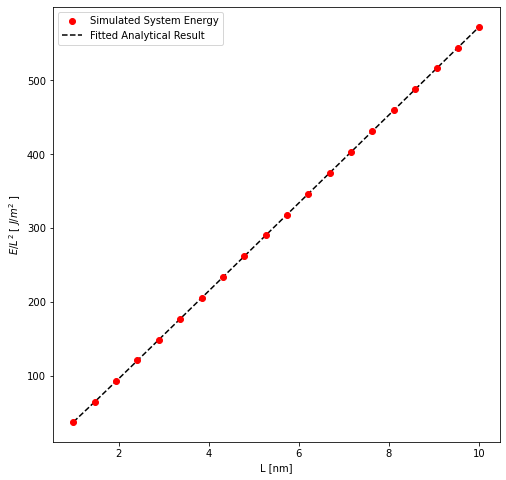

In [15]:
mu_low = 1.12e-18 # chemical potential of fermion gas in J (copper)
beta_low = 10/(mu_low) # set beta potential such that beta*mu = 10
T_low = 1/(kB*beta_low) # definition of temperature from thermodynamic beta

# Calculate the energy of the system from L of 1 nm to 10 nm
L_low, E_low = system_energy(beta_low, mu_low, 1e-9, 1e-8, n_L=20, n_max=100)

# Fit the data to determine the best-fit parameters (popt_low)
popt_low, pcov_low = curve_fit(expected_energy_relation, L_low, E_low/(L_low**2), [1e10, 0, 1e-18])
print(f"Calculated parameters:  rho = {popt_low[0]:.2e} J/m^3,  sigma = {popt_low[1]:.2e} J/m^2,  " +\
      f"delta_E = {popt_low[2]:.2e} J")

### Plotting
plt.figure(figsize=(8, 8))
# plt.title(r'''Average System Energy Over Box Side Length Squared
# [ $J/{m^2}$ ] vs Side Length [nm] for T = 3K and $\beta\mu = 10$''')
plt.xlabel('L [nm]')
plt.ylabel(r'$E/{L^2}$ [ $J/{m^2}$ ]')

plt.scatter(L_low*1e9, E_low/(L_low**2), label='Simulated System Energy', zorder=5, c='r')
plt.plot(L_low*1e9, expected_energy_relation(L_low, *popt_low), c='k', ls='--', label='Fitted Analytical Result')
plt.legend()
plt.savefig('figure1.pdf')

81100.65170166545 8.928571428571429e+17 1.12e-18
Calculated parameters:  rho = 3.69e+11 J/m^3,  sigma = -9.58e+00 J/m^2,  delta_E = -2.69e-17 J


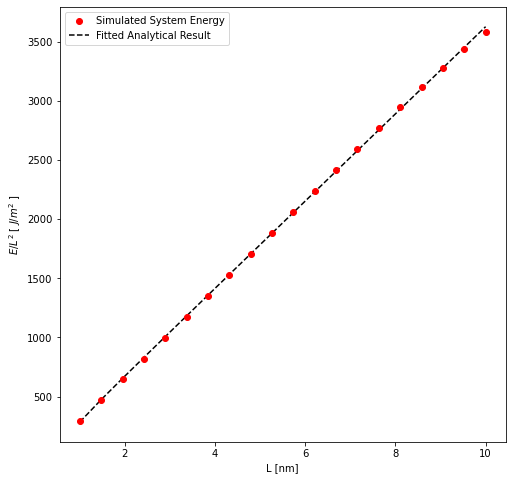

In [18]:
mu_medium = 1.12e-18 # chemical potential of fermion gas in J (copper)
beta_medium = 1/(mu_medium) # set beta potential such that beta*mu = 1
T_medium = 1/(kB*beta_medium) # definition of temperature from thermodynamic beta

# Calculate the energy of the system from L of 1 nm to 10 nm
L_medium, E_medium = system_energy(beta_medium, mu_medium, 1e-9, 1e-8, n_L=20, n_max=100)

# Fit the data to determine the best-fit parameters (popt_medium)
popt_medium, pcov_medium = curve_fit(expected_energy_relation, L_medium, E_medium/(L_medium**2), [1e11, -10, 1e-17])
print(f"Calculated parameters:  rho = {popt_medium[0]:.2e} J/m^3,  sigma = {popt_medium[1]:.2e} J/m^2,  " +\
      f"delta_E = {popt_medium[2]:.2e} J")

### Plotting
plt.figure(figsize=(8,8))
# plt.title(r'''Average System Energy Over Box Side Length Squared
# [ $J/{m^2}$ ] vs Side Length [nm] for T = 300K and $\beta\mu = 1$''')
plt.xlabel('L [nm]')
plt.ylabel(r'$E/{L^2}$ [ $J/{m^2}$ ]')

plt.scatter(L_medium*1e9, E_medium/(L_medium**2), label='Simulated System Energy', zorder=5, c='r')
plt.plot(L_medium*1e9, expected_energy_relation(L_medium, *popt_medium), c='k', ls='--', label='Fitted Analytical Result')
plt.legend()
plt.savefig('figure2.pdf')

811006.5170166546 8.928571428571429e+16 1.12e-18
Calculated parameters:  rho = 5.58e+13 J/m^3,  sigma = -6.85e+02 J/m^2,  delta_E = 6.17e-18 J


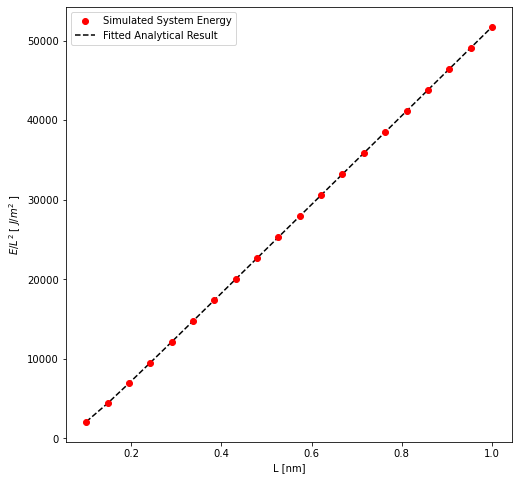

In [25]:
mu_high = 1.12e-18 # chemical potential of fermion gas in J (copper)
beta_high = 0.1/(mu_high) # set beta potential such that beta*mu = 0.1
T_high = 1/(kB*beta_high) # definition of temperature from thermodynamic beta

# Calculate the energy of the system from L of 0.1 nm to 1 nm
L_high, E_high = system_energy(beta_high, mu_high, 1e-10, 1e-9, n_L=20, n_max=100)

# Fit the data to determine the best-fit parameters (popt_high)
popt_high, pcov_high = curve_fit(expected_energy_relation, L_high, E_high/(L_high**2), [1e13, -1e2, 1e-18])
print(f"Calculated parameters:  rho = {popt_high[0]:.2e} J/m^3,  sigma = {popt_high[1]:.2e} J/m^2,  " +\
      f"delta_E = {popt_high[2]:.2e} J")

### Plotting
plt.figure(figsize=(8,8))
# plt.title(r'''Average System Energy Over Box Side Length Squared
# [ $J/{m^2}$ ] vs Side Length [nm] for T = 3000K and $\beta\mu = 0.1.$''')
plt.xlabel('L [nm]')
plt.ylabel(r'$E/{L^2}$ [ $J/{m^2}$ ]')

plt.scatter(L_high*1e9, E_high/(L_high**2), label='Simulated System Energy', zorder=5, c='r')
plt.plot(L_high*1e9, expected_energy_relation(L_high, *popt_high), c='k', ls='--', label='Fitted Analytical Result')
plt.legend()
plt.savefig('figure3.pdf')

In [26]:
@njit
def system_particle_number(beta, mu, L_min, L_max, n_L=100, n_max=100):
    ''' Function that computes the average number of particles in a system of fermions
        in a 3D box by summing over all combinations of quantum numbers to a specified
        upper limit. Energy values for a range of lengths are computed and returned.
        
    Inputs:
        beta: `float`
            Thermodynamic beta (1/kT) in units of eV
        mu: `float`
            Chemical potential of fermi gas in units of eV
        L_min: `float`
            Lower limit of box side length values
        L_max: `float`
            Higher limit of box side length values
        n_L: `integer`
            Number of values between L_min and L_max to use for energy calculation
        n_max: `integer`
            Maximum number of each spatial quantum number to iterate through
        
    Returns: 
        L: `numpy array`
            Values for the box side length used in the system energy calculation
        N: `numpy array`
            Calculated average particle number at each value for box side length
    '''

    L = np.linspace(L_min, L_max, n_L)# array of L values to iterate through
    N = np.zeros(n_L) # empty array to store particle number of system for each L
    
    for index, l in enumerate(L): # iterate through each box side length
        
        # iterate through combinations of quantum numbers nx, ny, and nz up to n_max
        for nx in range(1, n_max):
            for ny in range(1, n_max):
                for nz in range(1, n_max):
                    
                    n_sq_mag = nx**2 + ny**2 + nz**2 # square magnitude of n vector

                    # sum over FD distribution yields particle number,
                    # factor of 2 added to account for spin degeneracy of quantum states
                    N[index] += 2*FD_distribution(n_sq_mag, l, beta, mu)

    return L, N

In [28]:
# calculate the total number of particles in each temperature regime as a function of L
# using the same bounds as determined as accurate for the system energy calculation
_, N_low = system_particle_number(beta_low, mu_low, 1e-9, 1e-8, n_L=20, n_max=100)
_, N_medium = system_particle_number(beta_medium, mu_medium, 1e-9, 1e-8, 20, 100)
_, N_high = system_particle_number(beta_high, mu_high, 1e-10, 1e-9, n_L=20, n_max=100)

In [29]:
# calculate the average particle number density within each temperature regime
print(f"Low Temperature Particle Density: {np.average(N_low/(L_low**3)):.2e}")
print(f"Medium Temperature Particle Density: {np.average(N_medium/(L_medium**3)):.2e}")
print(f"High Temperature Particle Density: {np.average(N_high/(L_high**3)):.2e}")

Low Temperature Particle Density: 7.37e+28
Medium Temperature Particle Density: 1.61e+29
High Temperature Particle Density: 2.16e+30
